<a href="https://colab.research.google.com/github/blackst3r/chenwei.github.io/blob/main/transfer_learnning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 1s 0us/step


In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # di

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [ ]:
batch_size = 128
epochs = 3
IMG_HEIGHT = 150
IMG_WIDTH = 150
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

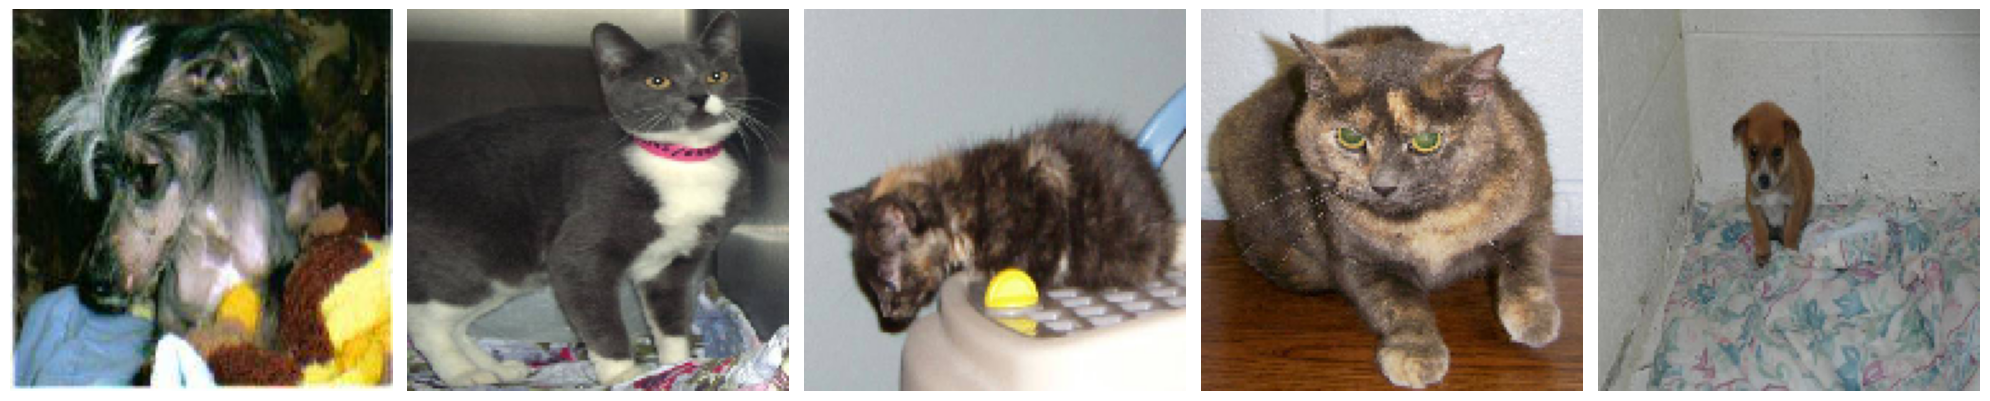

In [ ]:
plotImages(sample_training_images[:5])

In [ ]:
validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_dataset,
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, 160, 160, None), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE,), dtype=tf.float32)))

# Now you can use prefetch
validation_dataset = validation_dataset.prefetch(1)

In [ ]:
validation_dataset = validation_dataset.skip(30)

In [ ]:
validation_dataset

<SkipDataset element_spec=(TensorSpec(shape=(32, 160, 160, None), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.float32, name=None))>

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AttributeError: 'DirectoryIterator' object has no attribute '_variant_tensor'

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

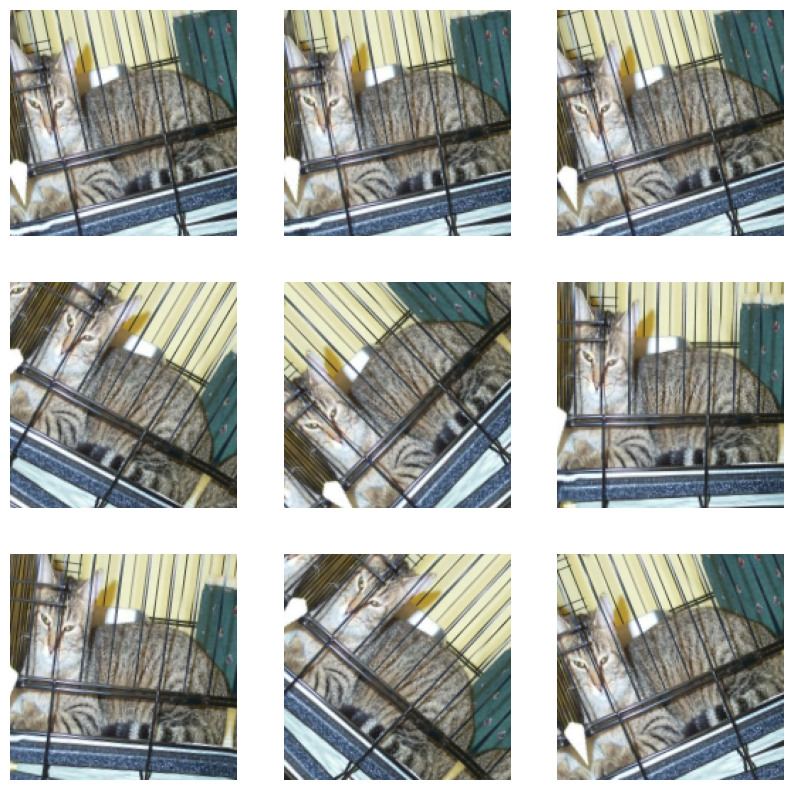

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 99ms/step - loss: 0.9190 - accuracy: 0.4827


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.92
initial accuracy: 0.48


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 156ms/step - loss: 0.7556 - accuracy: 0.5750 - val_loss: 0.5572 - val_accuracy: 0.6807
Epoch 2/10
63/63 [==============================] - 10s 155ms/step - loss: 0.5517 - accuracy: 0.7035 - val_loss: 0.4172 - val_accuracy: 0.7933
Epoch 3/10
63/63 [==============================] - 10s 164ms/step - loss: 0.4635 - accuracy: 0.7685 - val_loss: 0.3191 - val_accuracy: 0.8800
Epoch 4/10
63/63 [==============================] - 10s 163ms/step - loss: 0.3832 - accuracy: 0.8295 - val_loss: 0.2713 - val_accuracy: 0.8899
Epoch 5/10
63/63 [==============================] - 10s 165ms/step - loss: 0.3407 - accuracy: 0.8405 - val_loss: 0.2185 - val_accuracy: 0.9208
Epoch 6/10
63/63 [==============================] - 10s 163ms/step - loss: 0.3074 - accuracy: 0.8545 - val_loss: 0.1952 - val_accuracy: 0.9394
Epoch 7/10
63/63 [==============================] - 10s 153ms/step - loss: 0.2718 - accuracy: 0.8860 - val_loss: 0.1721 - val_accuracy: 0.9431

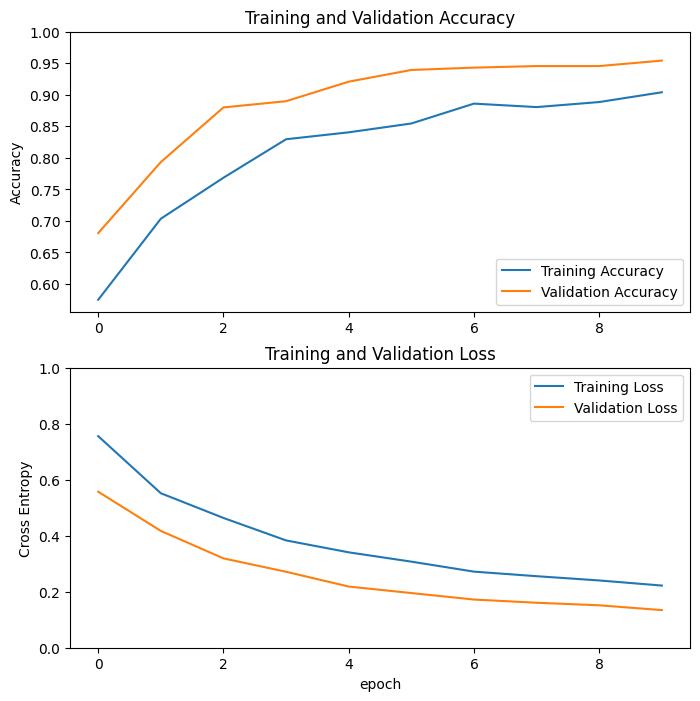

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 18s 225ms/step - loss: 0.1718 - accuracy: 0.9295 - val_loss: 0.0614 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 14s 214ms/step - loss: 0.1174 - accuracy: 0.9535 - val_loss: 0.0504 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 13s 211ms/step - loss: 0.1189 - accuracy: 0.9490 - val_loss: 0.0502 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 13s 211ms/step - loss: 0.0915 - accuracy: 0.9650 - val_loss: 0.0442 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 13s 206ms/step - loss: 0.0909 - accuracy: 0.9610 - val_loss: 0.0501 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 13s 212ms/step - loss: 0.0785 - accuracy: 0.9590 - val_loss: 0.0390 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 13s 205ms/step - loss: 0.0779 - accuracy: 0.9655 - val_loss: 0.0640 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

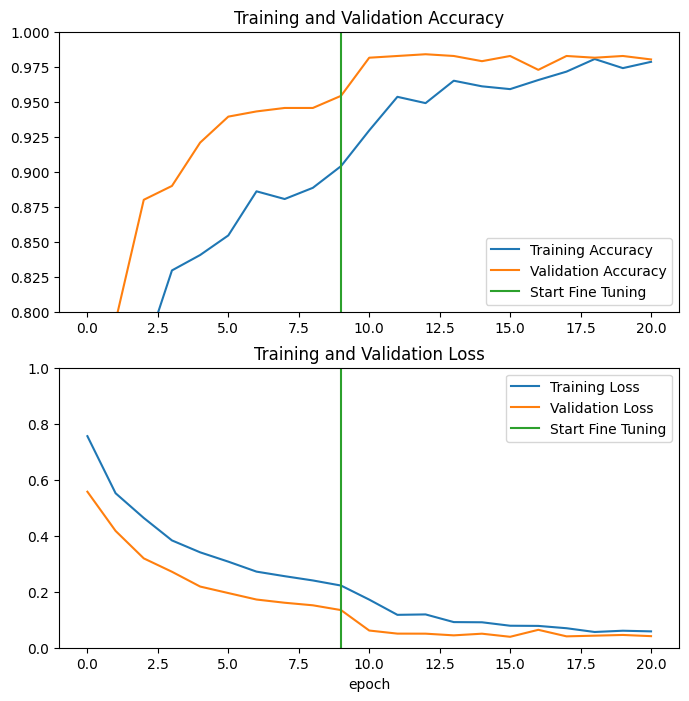

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 101ms/step - loss: 0.0462 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


In [ ]:
image_batch

array([[[[184.0625   , 188.0625   , 200.0625   ],
         [188.3129   , 192.3129   , 204.3129   ],
         [190.6875   , 194.6875   , 206.6875   ],
         ...,
         [142.3125   , 148.6875   , 165.625    ],
         [140.375    , 151.625    , 168.1875   ],
         [140.       , 152.       , 164.       ]],

        [[185.06876  , 189.06876  , 201.06876  ],
         [189.19376  , 193.19376  , 205.19376  ],
         [192.00195  , 196.00195  , 208.00195  ],
         ...,
         [144.31876  , 151.00626  , 167.00235  ],
         [142.00117  , 154.00626  , 170.00626  ],
         [142.00626  , 154.00626  , 166.00626  ]],

        [[186.08398  , 190.08398  , 202.08398  ],
         [190.25195  , 194.25195  , 206.25195  ],
         [193.3125   , 197.3125   , 209.3125   ],
         ...,
         [146.34375  , 153.26758  , 167.71875  ],
         [143.4668   , 157.0918   , 170.6543   ],
         [144.34375  , 156.34375  , 168.34375  ]],

        ...,

        [[ 27.115234 ,  55.927734 , 11

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

2023-04-27 20:07:08.567283: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (32, 160, 160, 3) where an element of shape (20, 150, 150, 3) was expected.
Traceback (most recent call last):

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (32, 160, 160, 3) where an element of shape (20, 150, 150, 3) was expected.


2023-04-27 20:07:10.344922: W tensorflow/core/framework/op_kernel.cc:1768] INVALID

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element of shape (32, 160, 160, 3) where an element of shape (20, 150, 150, 3) was expected.
Traceback (most recent call last):

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (32, 160, 160, 3) where an element of shape (20, 150, 150, 3) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

2023-04-27 20:07:10.665075: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (32, 160, 160, 3) where an element of shape (20, 150, 150, 3) was expected.
Traceback (most recent call last):

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/chenweiwang/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (32, 160, 160, 3) where an element of shape (20, 150, 150, 3) was expected.


